#  Решение задачи классификации при помощи пакета `torch`.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://lightning.ai/docs/torchmetrics/stable/
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://www.learnpytorch.io/02_pytorch_classification/
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb45
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b7
* https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
* https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss52

## Задачи для совместного разбора

In [ ]:
!pip install torchtyping

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

1\. Обсудите подходы к решению задачи классификации на примере синтетического датасета.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу классификации. Разделите датасет на обучающую и тестовую выборку в соотношении 80% на 20%. В качестве функции потерь используйте реализацию `CrossEntropyLoss` из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`.

Используйте модель, состоящую из двух слоев:
1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 2 нейронами.

Выведите график изменения значения функции потерь в процессе обучения. Выведите на экран значения Accuracy, Precision, Recall и F1 для обучающего и тестового множества.

Выведите на экран облако точек с цветом, соответствующим предсказаниям модели на всем датасете (и обучающей, и тестовой части).

- [ ] Проверено на семинаре


In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

In [ ]:
!pip install torchmetrics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.datasets import make_circles
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X_np)
y = torch.LongTensor(y_np)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Linear(10, 2)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=2, average='macro').to(device)

epochs = 100
train_losses, train_f1_scores, test_f1_scores = [], [], []
for epoch in range(1, epochs + 1):
    model.train()
    f1_metric.reset()
    epoch_loss = 0


    for inputs_batch, targets_batch in train_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)

        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    f1_metric.reset()
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
            outputs = model(inputs_batch)
            preds = torch.argmax(outputs, dim=1)
            f1_metric.update(preds, targets_batch)

    test_f1 = f1_metric.compute().item()
    test_f1_scores.append(test_f1)

    if epoch % 20 == 0:
        print(f"Эпоха {epoch}/{epochs} -> Loss: {train_losses[-1]:.4f}, Test F1: {test_f1:.4f}")

accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
precision_metric = torchmetrics.Precision(task='multiclass', num_classes=2, average='macro').to(device)
recall_metric = torchmetrics.Recall(task='multiclass', num_classes=2, average='macro').to(device)
final_f1 = test_f1_scores[-1]

with torch.no_grad():
    model.eval()
    for inputs_batch, targets_batch in test_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
        outputs = model(inputs_batch)
        preds = torch.argmax(outputs, dim=1)
        accuracy_metric.update(preds, targets_batch)
        precision_metric.update(preds, targets_batch)
        recall_metric.update(preds, targets_batch)

print(f"  Accuracy:  {accuracy_metric.compute().item():.4f}")
print(f"  Precision: {precision_metric.compute().item():.4f}")
print(f"  Recall:    {recall_metric.compute().item():.4f}")
print(f"  F1 Score:  {final_f1:.4f}")

Используется устройство: cpu
Эпоха 20/100 -> Loss: 0.7299, Test F1: 0.3311
Эпоха 40/100 -> Loss: 0.7038, Test F1: 0.3311
Эпоха 60/100 -> Loss: 0.7596, Test F1: 0.3355
Эпоха 80/100 -> Loss: 0.7154, Test F1: 0.3311
Эпоха 100/100 -> Loss: 0.7164, Test F1: 0.3355
  Accuracy:  0.5050
  Precision: 0.2525
  Recall:    0.5000
  F1 Score:  0.3355


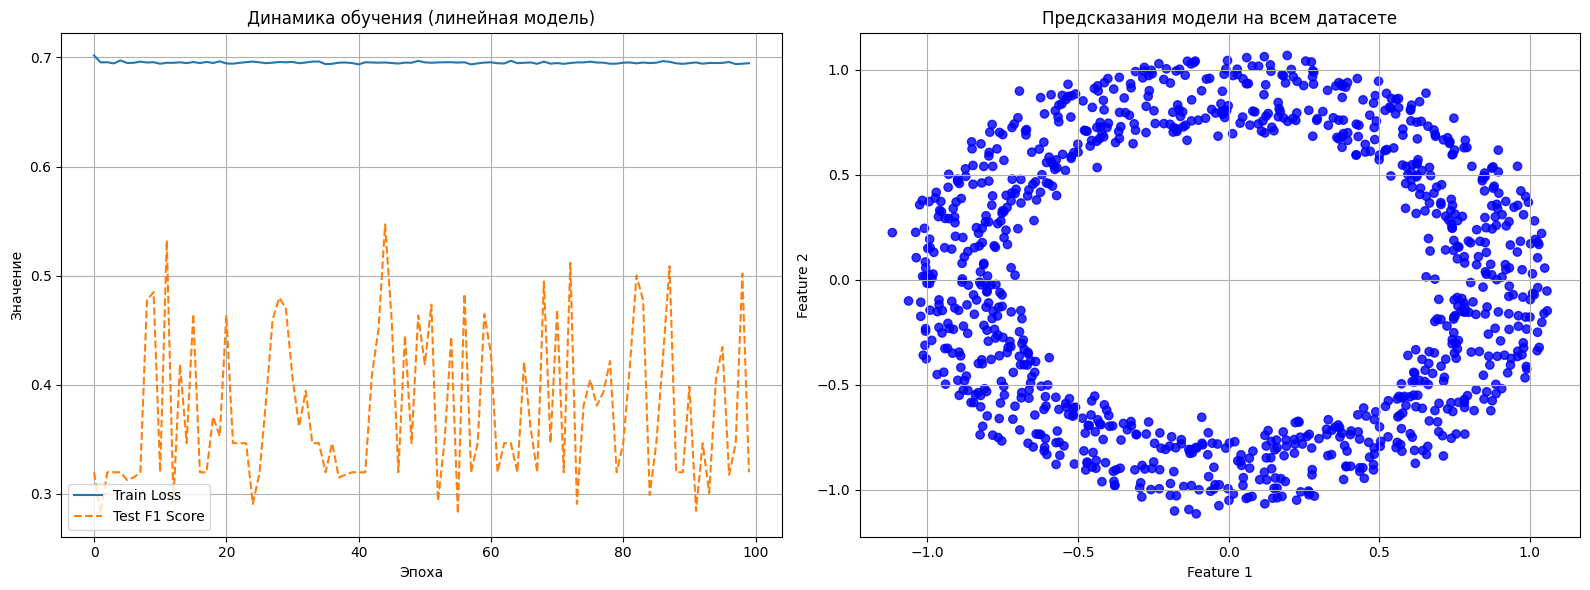

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_f1_scores, label='Test F1 Score', linestyle='--')
axes[0].set_title('Динамика обучения (линейная модель)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True)

model.eval()
with torch.no_grad():
    all_preds = model(X.to(device)).argmax(dim=1).cpu().numpy()

axes[1].scatter(X[:, 0], X[:, 1], c=all_preds, cmap='bwr', alpha=0.8)
axes[1].set_title('Предсказания модели на всем датасете')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True)

plt.tight_layout()
plt.show()


<p class="task" id="2"></p>

2\. Повторите задачу 1, используя другую архитектуру нейронной сети.

1. Полносвязный слой с 10 нейронами;
2. Функция активации ReLU;
3. Полносвязный слой с 2 нейронами.

- [ ] Проверено на семинаре

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X_np)
y = torch.LongTensor(y_np)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=2, average='macro').to(device)

epochs = 100
train_losses, test_f1_scores = [], []

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0

    for inputs_batch, targets_batch in train_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)

        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    f1_metric.reset()
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
            outputs = model(inputs_batch)
            preds = torch.argmax(outputs, dim=1)
            f1_metric.update(preds, targets_batch)

    test_f1 = f1_metric.compute().item()
    test_f1_scores.append(test_f1)

    if epoch % 20 == 0:
        print(f"Эпоха {epoch}/{epochs} -> Loss: {train_losses[-1]:.4f}, Test F1: {test_f1:.4f}")

accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
precision_metric = torchmetrics.Precision(task='multiclass', num_classes=2, average='macro').to(device)
recall_metric = torchmetrics.Recall(task='multiclass', num_classes=2, average='macro').to(device)
final_f1 = test_f1_scores[-1]

with torch.no_grad():
    model.eval()
    accuracy_metric.reset(); precision_metric.reset(); recall_metric.reset()
    for inputs_batch, targets_batch in test_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
        outputs = model(inputs_batch)
        preds = torch.argmax(outputs, dim=1)
        accuracy_metric.update(preds, targets_batch)
        precision_metric.update(preds, targets_batch)
        recall_metric.update(preds, targets_batch)

print(f"  Accuracy:  {accuracy_metric.compute().item():.4f}")
print(f"  Precision: {precision_metric.compute().item():.4f}")
print(f"  Recall:    {recall_metric.compute().item():.4f}")
print(f"  F1 Score:  {final_f1:.4f}")

Используется устройство: cpu
Эпоха 20/100 -> Loss: 0.6286, Test F1: 0.8093
Эпоха 40/100 -> Loss: 0.4794, Test F1: 0.9350
Эпоха 60/100 -> Loss: 0.3153, Test F1: 0.8788
Эпоха 80/100 -> Loss: 0.2205, Test F1: 0.9750
Эпоха 100/100 -> Loss: 0.1772, Test F1: 0.9600
  Accuracy:  0.9600
  Precision: 0.9611
  Recall:    0.9606
  F1 Score:  0.9600


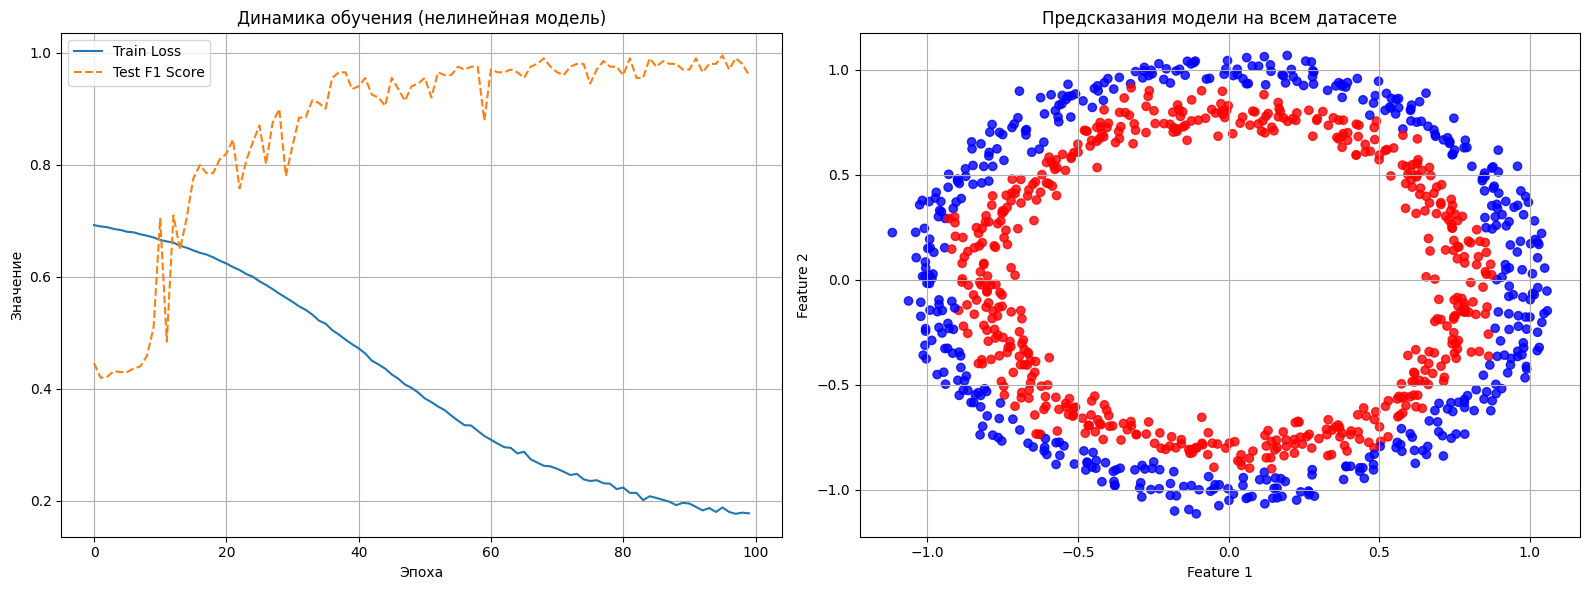

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_f1_scores, label='Test F1 Score', linestyle='--')
axes[0].set_title('Динамика обучения (нелинейная модель)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True)

model.eval()
with torch.no_grad():
    all_preds = model(X.to(device)).argmax(dim=1).cpu().numpy()

axes[1].scatter(X[:, 0], X[:, 1], c=all_preds, cmap='bwr', alpha=0.8)
axes[1].set_title('Предсказания модели на всем датасете')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True)

plt.tight_layout()
plt.show()


<p class="task" id="3"></p>

3\. `CrossEntropyLoss` может быть использована для задачи классификации на любое количество классов. Для задачи бинарной классификации существуют специфические функции потерь. Решите задачу 2, используя `BCEWithLogitsLoss` в качестве функции потерь.

- [ ] Проверено на семинаре

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X_np)
y = torch.FloatTensor(y_np).view(-1, 1)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
f1_metric = torchmetrics.F1Score(task='binary').to(device)

epochs = 100
train_losses, test_f1_scores = [], []

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0

    for inputs_batch, targets_batch in train_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)

        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    f1_metric.reset()
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
            outputs = model(inputs_batch)
            preds = torch.sigmoid(outputs) > 0.5
            f1_metric.update(preds, targets_batch.int())

    test_f1 = f1_metric.compute().item()
    test_f1_scores.append(test_f1)

    if epoch % 20 == 0:
        print(f"Эпоха {epoch}/{epochs} -> Loss: {train_losses[-1]:.4f}, Test F1: {test_f1:.4f}")

accuracy_metric = torchmetrics.Accuracy(task='binary').to(device)
precision_metric = torchmetrics.Precision(task='binary').to(device)
recall_metric = torchmetrics.Recall(task='binary').to(device)
final_f1 = test_f1_scores[-1]

with torch.no_grad():
    model.eval()
    accuracy_metric.reset(); precision_metric.reset(); recall_metric.reset()
    for inputs_batch, targets_batch in test_loader:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
        outputs = model(inputs_batch)
        preds = torch.sigmoid(outputs) > 0.5
        accuracy_metric.update(preds, targets_batch.int())
        precision_metric.update(preds, targets_batch.int())
        recall_metric.update(preds, targets_batch.int())

print(f"  Accuracy:  {accuracy_metric.compute().item():.4f}")
print(f"  Precision: {precision_metric.compute().item():.4f}")
print(f"  Recall:    {recall_metric.compute().item():.4f}")
print(f"  F1 Score:  {final_f1:.4f}")

Используется устройство: cpu
Эпоха 20/100 -> Loss: 0.6814, Test F1: 0.6829
Эпоха 40/100 -> Loss: 0.6479, Test F1: 0.8070
Эпоха 60/100 -> Loss: 0.5696, Test F1: 0.8543
Эпоха 80/100 -> Loss: 0.4617, Test F1: 0.8901
Эпоха 100/100 -> Loss: 0.3560, Test F1: 0.9381
  Accuracy:  0.9400
  Precision: 0.9100
  Recall:    0.9681
  F1 Score:  0.9381


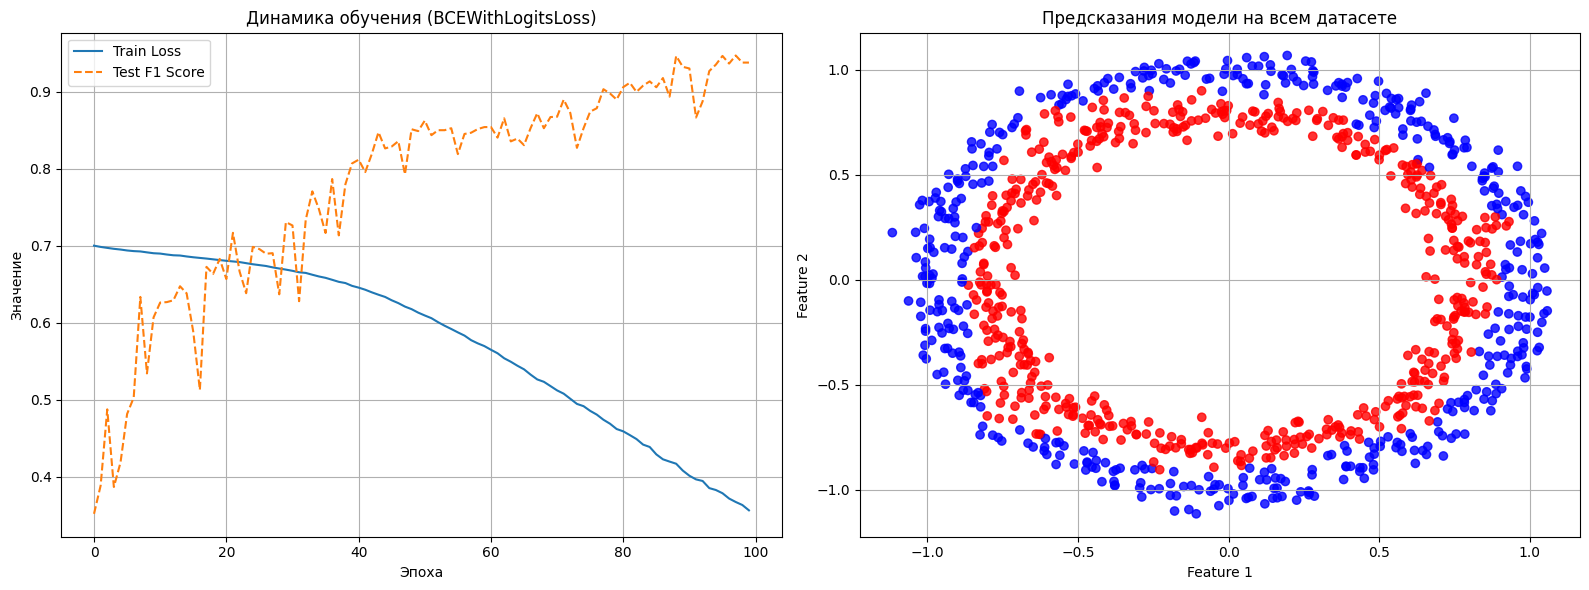

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_f1_scores, label='Test F1 Score', linestyle='--')
axes[0].set_title('Динамика обучения (BCEWithLogitsLoss)')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True)

model.eval()
with torch.no_grad():
    all_preds = (torch.sigmoid(model(X.to(device))) > 0.5).int().cpu().numpy()

axes[1].scatter(X_np[:, 0], X_np[:, 1], c=all_preds, cmap='bwr', alpha=0.8)
axes[1].set_title('Предсказания модели на всем датасете')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True)

plt.tight_layout()
plt.show()

<p class="task" id="4"></p>

4\. На практике часто задача классификации является несбалансированной. В файлах каталога `imb_task` содержится несбалансированный набор данных. Обучите модель без учета несбалансированности классов (аналогично предыдущим заданиям, можно использовать любую подходящую функцию потерь). Повысьте качество модели (в смысле F1) путем модификации функции потерь (указания специального аргумента, позволяющего учесть несбалансированность классов).

- [ ] Проверено на семинаре

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X_np)
y = torch.LongTensor(y_np)

indices_class_0 = np.where(y_np == 0)[0]
indices_class_1 = np.where(y_np == 1)[0]
np.random.shuffle(indices_class_1)
indices_class_1_subset = indices_class_1[:int(len(indices_class_1) * 0.1)]

imbalanced_indices = np.concatenate([indices_class_0, indices_class_1_subset])
X_imb = X[imbalanced_indices]
y_imb = y[imbalanced_indices]

print(f"Размеры классов в несбалансированном датасете:")
print(f"  Класс 0: {len(indices_class_0)}")
print(f"  Класс 1: {len(indices_class_1_subset)}")

dataset = TensorDataset(X_imb, y_imb)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def create_model():
    return nn.Sequential(
        nn.Linear(2, 10),
        nn.ReLU(),
        nn.Linear(10, 2)
    ).to(device)

print("Обучение без учета дисбаланса")
model_naive = create_model()
criterion_naive = nn.CrossEntropyLoss()
optimizer_naive = optim.SGD(model_naive.parameters(), lr=0.1)
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=2, average='macro').to(device)

for epoch in range(1, 51):
    model_naive.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_naive.zero_grad()
        outputs = model_naive(inputs)
        loss = criterion_naive(outputs, targets)
        loss.backward()
        optimizer_naive.step()

model_naive.eval()
f1_metric.reset()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = torch.argmax(model_naive(inputs), dim=1)
        f1_metric.update(preds, targets)

f1_naive = f1_metric.compute().item()
print(f"Итоговый F1-Score (без учета весов): {f1_naive:.4f}")



print("Обучение с взвешенной функцией потерь")

y_train_tensors = train_dataset.dataset.tensors[1][train_dataset.indices]
class_counts = torch.bincount(y_train_tensors)
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print(f"Рассчитанные веса для классов: {class_weights.cpu().numpy()}")

model_weighted = create_model()
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
optimizer_weighted = optim.SGD(model_weighted.parameters(), lr=0.1)

for epoch in range(1, 51):
    model_weighted.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_weighted.zero_grad()
        outputs = model_weighted(inputs)
        loss = criterion_weighted(outputs, targets)
        loss.backward()
        optimizer_weighted.step()

model_weighted.eval()
f1_metric.reset()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = torch.argmax(model_weighted(inputs), dim=1)
        f1_metric.update(preds, targets)

f1_weighted = f1_metric.compute().item()
print(f"Итоговый F1-Score (с учетом весов): {f1_weighted:.4f}")

Используется устройство: cpu
Размеры классов в несбалансированном датасете:
  Класс 0: 500
  Класс 1: 50
Обучение без учета дисбаланса
Итоговый F1-Score (без учета весов): 0.4811
Обучение с взвешенной функцией потерь
Рассчитанные веса для классов: [0.09545454 0.9045454 ]
Итоговый F1-Score (с учетом весов): 0.6700


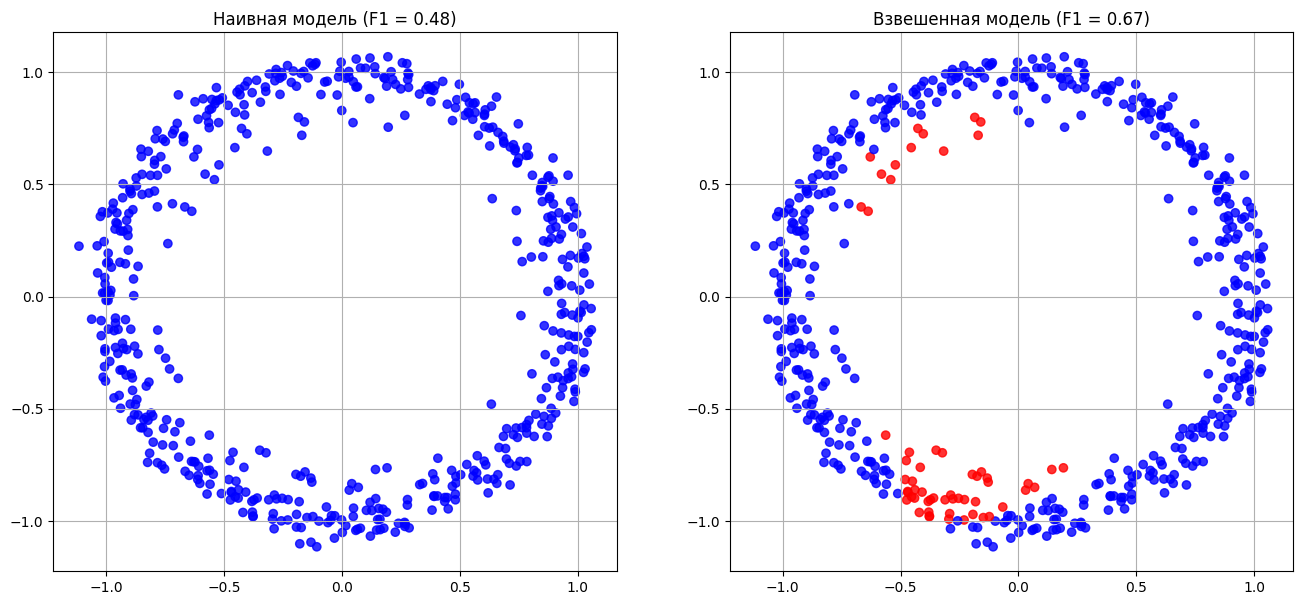

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

with torch.no_grad():
    preds_naive = torch.argmax(model_naive(X_imb.to(device)), dim=1).cpu()
axes[0].scatter(X_imb[:, 0], X_imb[:, 1], c=preds_naive, cmap='bwr', alpha=0.8)
axes[0].set_title(f'Наивная модель (F1 = {f1_naive:.2f})')
axes[0].grid(True)

with torch.no_grad():
    preds_weighted = torch.argmax(model_weighted(X_imb.to(device)), dim=1).cpu()
axes[1].scatter(X_imb[:, 0], X_imb[:, 1], c=preds_weighted, cmap='bwr', alpha=0.8)
axes[1].set_title(f'Взвешенная модель (F1 = {f1_weighted:.2f})')
axes[1].grid(True)

plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, повысив качество модели за счет использования `WeightedRandomSampler` вместо модификации функции потерь.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import WeightedRandomSampler

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Используется устройство: {device}")

X_np, y_np = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X_np)
y = torch.LongTensor(y_np)

indices_class_0 = np.where(y_np == 0)[0]
indices_class_1 = np.where(y_np == 1)[0]
np.random.shuffle(indices_class_1)
indices_class_1_subset = indices_class_1[:int(len(indices_class_1) * 0.1)]

imbalanced_indices = np.concatenate([indices_class_0, indices_class_1_subset])
X_imb = X[imbalanced_indices]
y_imb = y[imbalanced_indices]

print(f"Размеры классов в несбалансированном датасете:")
print(f"  Класс 0: {len(indices_class_0)}")
print(f"  Класс 1: {len(indices_class_1_subset)}")

dataset = TensorDataset(X_imb, y_imb)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_train_tensors = train_dataset.dataset.tensors[1][train_dataset.indices]

class_counts = torch.bincount(y_train_tensors)
class_weights = 1. / class_counts.float()

sample_weights = torch.tensor([class_weights[t] for t in y_train_tensors])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_weighted = DataLoader(train_dataset, batch_size=16, sampler=sampler)

model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=2, average='macro').to(device)

epochs = 100
train_losses, test_f1_scores = [], []

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0

    for inputs_batch, targets_batch in train_loader_weighted:
        inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)

        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader_weighted))

    model.eval()
    f1_metric.reset()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = torch.argmax(model(inputs), dim=1)
            f1_metric.update(preds, targets)

    test_f1 = f1_metric.compute().item()
    test_f1_scores.append(test_f1)

    if epoch % 20 == 0:
        print(f"Эпоха {epoch}/{epochs} -> Loss: {train_losses[-1]:.4f}, Test F1: {test_f1:.4f}")

print(f"Итоговый F1-Score (с WeightedRandomSampler): {test_f1_scores[-1]:.4f}")

Используется устройство: cpu
Размеры классов в несбалансированном датасете:
  Класс 0: 500
  Класс 1: 50
Эпоха 20/100 -> Loss: 0.6333, Test F1: 0.4868
Эпоха 40/100 -> Loss: 0.5573, Test F1: 0.6075
Эпоха 60/100 -> Loss: 0.4679, Test F1: 0.7440
Эпоха 80/100 -> Loss: 0.3625, Test F1: 0.7675
Эпоха 100/100 -> Loss: 0.2811, Test F1: 0.7954
Итоговый F1-Score (с WeightedRandomSampler): 0.7954


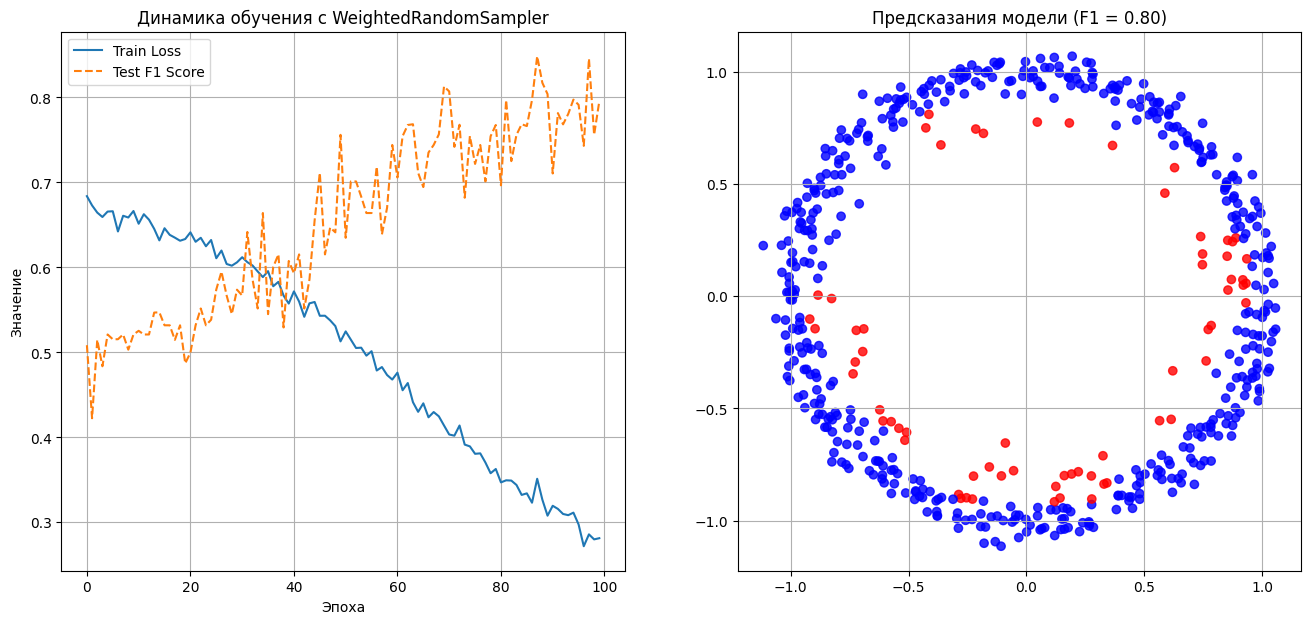

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_f1_scores, label='Test F1 Score', linestyle='--')
axes[0].set_title('Динамика обучения с WeightedRandomSampler')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Значение')
axes[0].legend()
axes[0].grid(True)

model.eval()
with torch.no_grad():
    preds = torch.argmax(model(X_imb.to(device)), dim=1).cpu()
axes[1].scatter(X_imb[:, 0], X_imb[:, 1], c=preds, cmap='bwr', alpha=0.8)
axes[1].set_title(f'Предсказания модели (F1 = {test_f1_scores[-1]:.2f})')
axes[1].grid(True)

plt.show()